In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
from pylab import rcParams
import statsmodels.api as sm
import itertools

Mounted at /content/drive


In [5]:
store_sales = pd.read_csv(
    '/content/drive/My Drive/Colab Notebooks/store-sales-time-series-forecasting/train.csv',
    usecols=['store_nbr', 'family', 'date', 'sales','onpromotion'],
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'sales': 'float32',
        'onpromotion': 'uint32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
store_sales['date'] = store_sales.date.dt.to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family', 'date']).sort_index()
average_sales = (
    store_sales
    .groupby('date').mean()
    .squeeze()
    .loc['2017']
)

In [7]:
train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/store-sales-time-series-forecasting/train.csv')
test = pd.read_csv('/content/drive/My Drive/Colab Notebooks/store-sales-time-series-forecasting/test.csv')

In [ ]:
train['date'] = pd.to_datetime(train['date'])
train.rename(columns={'sales': 'Sales'}, inplace=True)
train['Year'] = train['date'].dt.year
train['Month'] = train['date'].dt.month

In [ ]:
# Inspecting time series and rolling mean:
crossing = train[['date', 'Sales']].groupby('date').sum()
tseries = train.groupby(['date'])['Sales'].agg(
    ['sum']).reset_index().rename(columns={'sum': 'Sales'})
tseries = tseries.set_index('date')
y = tseries['Sales'].resample('MS').mean()

We can also visualize our data using a method called time-series decomposition that allows us to decompose our time series into three distinct components: trend, seasonality, and noise.

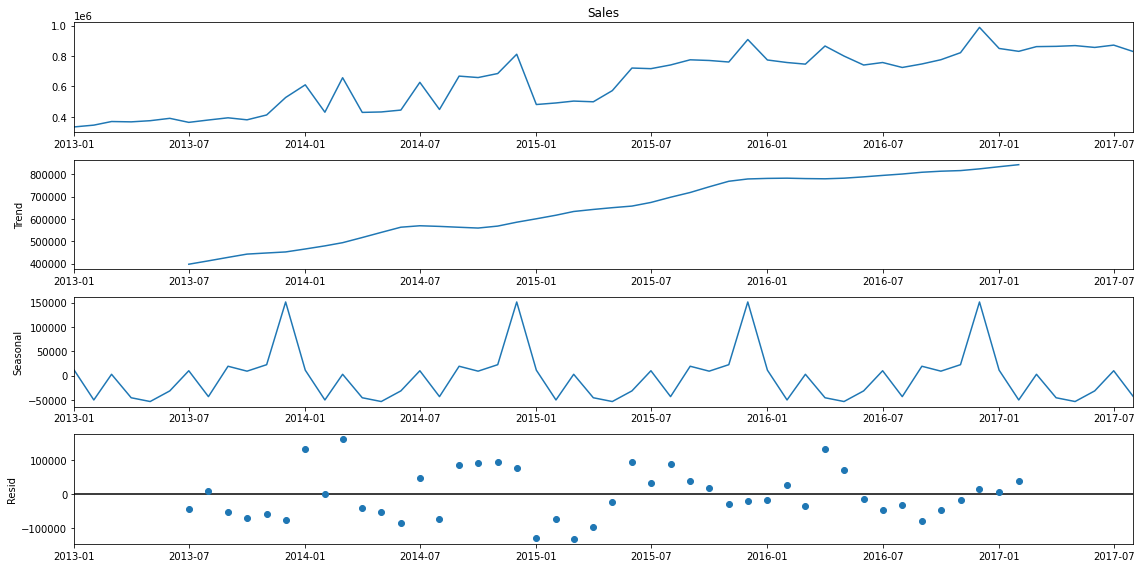

In [ ]:
rcParams['figure.figsize'] = 16, 8

decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

# **Time series forecasting with ARIMA**

We are going to apply one of the most commonly used method for time-series forecasting, known as ARIMA, which stands for Autoregressive Integrated Moving Average.

ARIMA models are denoted with the notation ARIMA(p, d, q). These three parameters account for seasonality, trend, and noise in data:

In [ ]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))


Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


This step is parameter Selection for our Store sales ARIMA Time Series Model. Our goal here is to use a “grid search” to find the optimal set of parameters that yields the best performance for our model.

In [ ]:
for param in pdq:
  for param_seasonal in seasonal_pdq:
    try:
      mod = sm.tsa.statespace.SARIMAX(y,
                                      order=param,
                                      seasonal_order=param_seasonal,
                                      enforce_stationarity=False,
                                      enforce_invertibility=False)
      results = mod.fit()
      print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
    except:
      continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1633.8455129211088
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1257.9995997911813
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:1160.7285700168436
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:2781.4444434641355
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:1171.0314611756453
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1149.0767486072866
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:857.8235781329272
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:2770.057504083298
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:1569.8164958072225
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:1220.4012021626068
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:1123.9889608326314
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:2741.4622111341414
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:1270.553369371854
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:1215.1138187567738
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:854.5417917204635
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:2739.3214850645822
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:1399.346995379829
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1126.77882841780

/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 1, 0)x(1, 1, 1, 12)12 - AIC:1210.5813027998674
ARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:1364.7363206890968
ARIMA(0, 1, 1)x(0, 0, 1, 12)12 - AIC:1059.4175736152124
ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:1081.3543227402229
ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:2618.9251069784427
ARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:1113.1752861034404
ARIMA(0, 1, 1)x(1, 0, 1, 12)12 - AIC:1061.2723243663334
ARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:803.7466364118249
ARIMA(0, 1, 1)x(1, 1, 1, 12)12 - AIC:2604.6183381143446
ARIMA(1, 0, 0)x(0, 0, 0, 12)12 - AIC:1426.1914416020043
ARIMA(1, 0, 0)x(0, 0, 1, 12)12 - AIC:1126.145475066224
ARIMA(1, 0, 0)x(0, 1, 0, 12)12 - AIC:1136.1059824972565
ARIMA(1, 0, 0)x(0, 1, 1, 12)12 - AIC:2818.0542041102285
ARIMA(1, 0, 0)x(1, 0, 0, 12)12 - AIC:1125.808255829666
ARIMA(1, 0, 0)x(1, 0, 1, 12)12 - AIC:1143.2548106404336
ARIMA(1, 0, 0)x(1, 1, 0, 12)12 - AIC:805.0325620595023
ARIMA(1, 0, 0)x(1, 1, 1, 12)12 - AIC:2815.7754538383506
ARIMA(1, 0, 1)x(0, 0, 0, 12)12 - AIC:1389.8435678593

In [ ]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 0),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3809      0.348     -1.095      0.274      -1.063       0.301
ar.S.L12      -0.4625      0.260     -1.776      0.076      -0.973       0.048
sigma2       1.42e+10    3.8e-12   3.73e+21      0.000    1.42e+10    1.42e+10


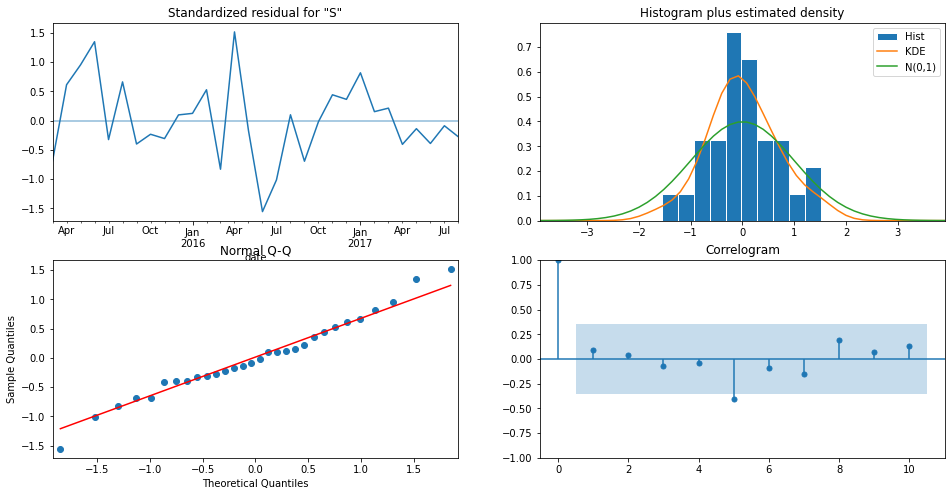

In [ ]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

our model diagnostics suggests that the model residuals are near normally distributed.

# **Validation Forecast**
To understand the accuracy of the forecast, predicted sales are compared to actual sales data. In the image below, forecast date is to start on 04-1-2017 to the end of the data. 

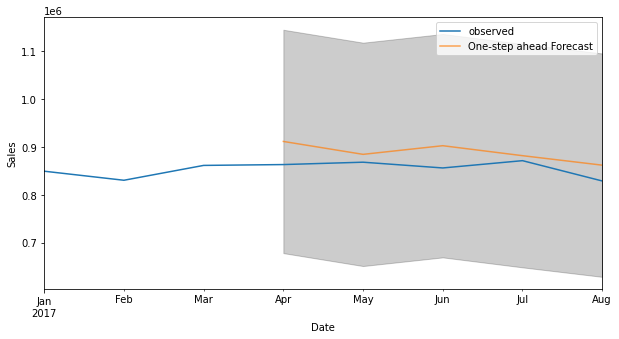

In [ ]:
pred = results.get_prediction(start=pd.to_datetime('2017-04-01'), dynamic=False)
pred_ci = pred.conf_int()

ax = y['2017':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(10, 5))

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.legend()

plt.show()

The line plot is showing the observed values compared to the rolling forecast predictions. Based on the plot, forecast prediction looks acceptable as it follows the actual data closely.

# **Forecasting**

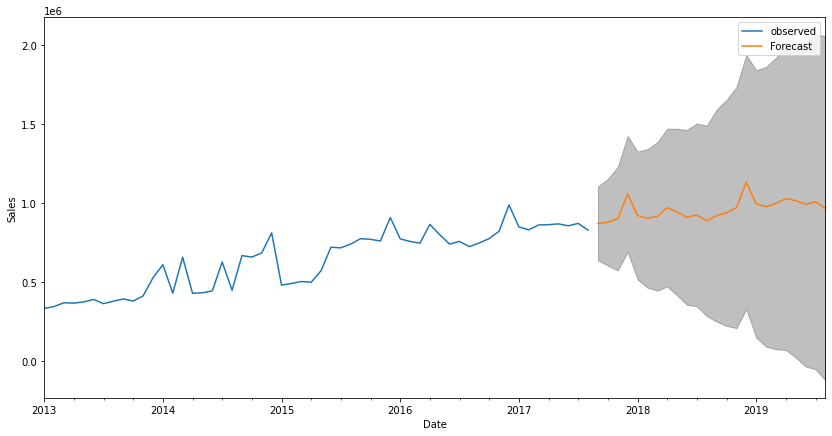

In [ ]:
pred_uc = results.get_forecast(steps=24)
pred_ci = pred_uc.conf_int()

ax = y.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Sales')

plt.legend()
plt.show()

Our model results are acceptable as it shows same trend of sales increase before year end. As we forecast further out into the future, it is natural for us to become less confident in our values. This is reflected by the confidence intervals generated by our model, which grow larger as we move further out into the future.

# **Root Mean Square Error**

In [ ]:
y_forecasted = pred.predicted_mean
y_truth = y['2017-01-01':]

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))


The Root Mean Squared Error of our forecasts is 34563.16


# **Data Processing for Neural Network**

In [1]:
!pip install chart-studio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.4/64.4 KB 1.9 MB/s eta 0:00:00


In [10]:
import warnings
from keras import optimizers
from keras.utils import plot_model
from keras.models import Sequential, Model
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Flatten
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import plotly.graph_objs as go
from chart_studio import plotly
from plotly.offline import init_notebook_mode, iplot
from keras.layers import Dropout

from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

%matplotlib inline
warnings.filterwarnings("ignore")
init_notebook_mode(connected=True)

In [21]:
train_df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/store-sales-time-series-forecasting/train.csv', parse_dates=['date'])
test_df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/store-sales-time-series-forecasting/test.csv', parse_dates=['date'])

In [22]:
# Creating a instance of label Encoder.
le = LabelEncoder()
 
# Using .fit_transform function to fit label
# encoder and return encoded label
label_1 = le.fit_transform(train_df['family'])
 
# printing label
print('Labels for family column are:' + str(label_1))
label_2 = le.fit_transform(train_df['store_nbr'])
print('Labels for store_nbr are:' +str(label_2))

Labels for family column are:[ 0  1  2 ... 30 31 32]
Labels for store_nbr are:[0 0 0 ... 8 8 8]


In [23]:
train_df.dtypes

id                      int64
date           datetime64[ns]
store_nbr               int64
family                 object
sales                 float64
onpromotion             int64
dtype: object

In [24]:
# dropping the categorical columns and adding label encoded values for these columns
train_df.drop(("family"), axis=1, inplace=True)
train_df.drop(("store_nbr"), axis=1, inplace=True)
 
# Appending the array to dataFrame

train_df["family"] = label_1
train_df["store_nbr"] = label_2

In [25]:
print('Min date from train set: %s' % train_df['date'].min().date())
print('Max date from train set: %s' % train_df['date'].max().date())

Min date from train set: 2013-01-01
Max date from train set: 2017-08-15


In [26]:
lag_size = (test_df['date'].max().date() - train_df['date'].max().date()).days
print('Max date from train set: %s' % train_df['date'].max().date())
print('Max date from test set: %s' % test_df['date'].max().date())
print('Forecast lag size', lag_size)

Max date from train set: 2017-08-15
Max date from test set: 2017-08-31
Forecast lag size 16


Transforming data

In [27]:
# working on date range staring from 2017 January
train_df = train_df[(train_df['date'] >= '2017-01-01')]

In [28]:
#Rearranging data
train_gp = train_df.sort_values('date').groupby(['family', 'store_nbr', 'date','onpromotion'], as_index=False)
train_gp = train_gp.agg({'sales':['mean']})
train_gp.columns = ['family', 'store_nbr', 'date', 'onpromotion','sales']
train_gp.head()

,family,store_nbr,date,onpromotion,sales
0,0,0,2017-01-01,0,0.0
1,0,0,2017-01-02,0,5.0
2,0,0,2017-01-03,0,4.0
3,0,0,2017-01-04,0,1.0
4,0,0,2017-01-05,0,2.0


In [29]:
# Transform series to supervised learning 

def series_to_supervised(data, window=1, lag=1, dropnan=True):
    cols, names = list(), list()
    # Input sequence (t-n, ... t-1)
    for i in range(window, 0, -1):
        cols.append(data.shift(i))
        names += [('%s(t-%d)' % (col, i)) for col in data.columns]
    # Current timestep (t=0)
    cols.append(data)
    names += [('%s(t)' % (col)) for col in data.columns]
    # Target timestep (t=lag)
    cols.append(data.shift(-lag))
    names += [('%s(t+%d)' % (col, lag)) for col in data.columns]
    # Put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # Drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [30]:
#use the current timestep and the last 29 to forecast 16 days ahead
window = 29
lag = lag_size
series = series_to_supervised(train_gp.drop('date', axis=1), window=window, lag=lag)
series.head()

,family(t-29),store_nbr(t-29),onpromotion(t-29),sales(t-29),family(t-28),store_nbr(t-28),onpromotion(t-28),sales(t-28),family(t-27),store_nbr(t-27),...,onpromotion(t-1),sales(t-1),family(t),store_nbr(t),onpromotion(t),sales(t),family(t+16),store_nbr(t+16),onpromotion(t+16),sales(t+16)
29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,...,0.0,0.0,0,0,0,3.0,0.0,0.0,0.0,3.0
30,0.0,0.0,0.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,...,0.0,3.0,0,0,0,5.0,0.0,0.0,0.0,3.0
31,0.0,0.0,0.0,4.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,5.0,0,0,0,7.0,0.0,0.0,0.0,7.0
32,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,...,0.0,7.0,0,0,0,3.0,0.0,0.0,0.0,3.0
33,0.0,0.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,...,0.0,3.0,0,0,0,1.0,0.0,0.0,0.0,0.0


In [31]:
#Drop rows with different item or store values than the shifted columns

last_item = 'family(t-%d)' % window
last_store = 'store_nbr(t-%d)' % window
last_onpromotion = 'onpromotion(t-%d)' % window
series = series[(series['store_nbr(t)'] == series[last_store])]
series = series[(series['family(t)'] == series[last_item])]
series = series[(series['onpromotion(t)'] == series[last_item])]

#Remove unwanted columns
columns_to_drop = [('%s(t+%d)' % (col, lag)) for col in ['family', 'store_nbr','onpromotion']]
for i in range(window, 0, -1):
    columns_to_drop += [('%s(t-%d)' % (col, i)) for col in ['family', 'store_nbr','onpromotion']]
series.drop(columns_to_drop, axis=1, inplace=True)
series.drop(['family(t)', 'store_nbr(t)'], axis=1, inplace=True)

In [32]:
# Label
labels_col = 'sales(t+%d)' % lag_size
labels = series[labels_col]
series = series.drop(labels_col, axis=1)

X_train, X_valid, Y_train, Y_valid = train_test_split(series, labels.values, test_size=0.2, random_state=0)
print('Train set shape', X_train.shape)
print('Validation set shape', X_valid.shape)
X_train.head()

Train set shape (10364, 31)
Validation set shape (2592, 31)


,sales(t-29),sales(t-28),sales(t-27),sales(t-26),sales(t-25),sales(t-24),sales(t-23),sales(t-22),sales(t-21),sales(t-20),...,sales(t-8),sales(t-7),sales(t-6),sales(t-5),sales(t-4),sales(t-3),sales(t-2),sales(t-1),onpromotion(t),sales(t)
4500,7.0,3.0,12.0,15.0,3.0,7.0,9.0,8.0,2.0,5.0,...,6.0,9.0,21.0,20.0,11.0,4.0,13.0,6.0,0,3.0
9652,4.0,5.0,3.0,2.0,3.0,3.0,2.0,3.0,9.0,9.0,...,4.0,1.0,2.0,6.0,1.0,0.0,2.0,1.0,0,0.0
10976,10.0,11.0,8.0,19.0,18.0,11.0,26.0,30.0,15.0,11.0,...,5.0,15.0,16.0,14.0,13.0,20.0,9.0,10.0,0,5.0
5895,7.0,3.0,1.0,3.0,4.0,9.0,0.0,1.0,6.0,5.0,...,5.0,7.0,1.0,4.0,16.0,8.0,1.0,2.0,0,3.0
73389,198.0,187.0,243.0,421.0,237.0,140.0,186.0,144.0,134.0,262.0,...,187.0,229.0,222.0,307.0,176.0,196.0,134.0,174.0,5,149.0


**First I will use CNN to train the model and check the RMSE**

In [35]:
# Set parameters
epochs = 1000
batch = 128
lr = 0.00001
adam = optimizers.Adam(lr)

In [33]:
# Reshaping data to use in CNN
X_train_series = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
X_valid_series = X_valid.values.reshape((X_valid.shape[0], X_valid.shape[1], 1))
print('Train set shape', X_train_series.shape)
print('Validation set shape', X_valid_series.shape)

Train set shape (10364, 31, 1)
Validation set shape (2592, 31, 1)


In [36]:
#I used one convolutional layer with kernel size =2, stride =1, 
#Rectified Linear Unit activation (ReLu). After the MaxPooling, 
#data was flattened and dense layers added with activation of ReLu. The model is compiled using a loss and optimizer arguments. 
#Dropout set at 0.2 to avoid overfitting and improve performance.
cnn = Sequential()
cnn.add(Conv1D(filters=128, kernel_size=2, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
cnn.add(MaxPooling1D(pool_size=2))
cnn.add(Flatten())
cnn.add(Dense (128, activation='relu'))
cnn.add(Dropout(0.2))
cnn.add(Dense (128, activation='relu'))
cnn.add(Dropout(0.2))
cnn.add(Dense (34, activation='relu'))
cnn.add(Dropout(0.2))
cnn.add(Dense(1))
cnn.compile(loss='mse', optimizer=adam)
cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 30, 128)           384       
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 15, 128)          0         
 1D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 1920)              0         
                                                                 
 dense_4 (Dense)             (None, 128)               245888    
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 128)               16512     
                                                      

In [37]:
import tensorflow as tf
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [38]:
cnn_history = cnn.fit(X_train_series, Y_train, validation_data=(X_valid_series, Y_valid), callbacks=[callback],epochs=epochs, verbose=2)

Epoch 1/1000
324/324 - 6s - loss: 28877.0176 - val_loss: 8793.6895 - 6s/epoch - 18ms/step
Epoch 2/1000
324/324 - 3s - loss: 15731.5010 - val_loss: 7158.6636 - 3s/epoch - 8ms/step
Epoch 3/1000
324/324 - 3s - loss: 15213.2764 - val_loss: 6681.5854 - 3s/epoch - 9ms/step
Epoch 4/1000
324/324 - 4s - loss: 13304.0420 - val_loss: 7237.4004 - 4s/epoch - 12ms/step
Epoch 5/1000
324/324 - 3s - loss: 14543.4180 - val_loss: 6149.9692 - 3s/epoch - 8ms/step
Epoch 6/1000
324/324 - 3s - loss: 13903.6172 - val_loss: 6219.0054 - 3s/epoch - 9ms/step
Epoch 7/1000
324/324 - 3s - loss: 13988.1035 - val_loss: 6226.2798 - 3s/epoch - 8ms/step
Epoch 8/1000
324/324 - 4s - loss: 13157.9854 - val_loss: 6497.8311 - 4s/epoch - 12ms/step
Epoch 9/1000
324/324 - 3s - loss: 13107.8516 - val_loss: 6227.1484 - 3s/epoch - 10ms/step
Epoch 10/1000
324/324 - 2s - loss: 13075.3037 - val_loss: 7404.6143 - 2s/epoch - 7ms/step


**LSTM**

Next I have used LSTM, a recurrent neural network model for the forecast

In [39]:
epochs = 1000
batch = 128
lr = 0.00001
adam = optimizers.Adam(lr)

In [40]:
#This will use one LSTM layer to process input sub-sequence of the time step, 
#followed by dense layers to interpret the summary of the input sequence. 
#The model uses the efficient Adam version of stochastic gradient descent and optimizes the mean squared error (‘mse‘) loss function.

#The model is then fit to the training data for predictions.

lstm = Sequential()
lstm.add(LSTM(256, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
lstm.add(Dense(128))
lstm.add(Dropout(0.2))
lstm.add(Dense(64))
lstm.add(Dense(32))
lstm.add(Dense(1))
lstm.compile(loss='mse', optimizer=adam)
lstm.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 256)               264192    
                                                                 
 dense_8 (Dense)             (None, 128)               32896     
                                                                 
 dropout_6 (Dropout)         (None, 128)               0         
                                                                 
 dense_9 (Dense)             (None, 64)                8256      
                                                                 
 dense_10 (Dense)            (None, 32)                2080      
                                                                 
 dense_11 (Dense)            (None, 1)                 33        
                                                                 
Total params: 307,457
Trainable params: 307,457
Non-tr

In [42]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [43]:
lstm_history = lstm.fit(X_train_series, Y_train, validation_data=(X_valid_series, Y_valid),callbacks=[callback], epochs=epochs, verbose=2)

Epoch 1/1000
324/324 - 41s - loss: 121715.5391 - val_loss: 50785.8906 - 41s/epoch - 127ms/step
Epoch 2/1000
324/324 - 41s - loss: 107709.5156 - val_loss: 37890.8906 - 41s/epoch - 128ms/step
Epoch 3/1000
324/324 - 37s - loss: 130817.6094 - val_loss: 28961.1426 - 37s/epoch - 113ms/step
Epoch 4/1000
324/324 - 40s - loss: 162820.9219 - val_loss: 41337.9453 - 40s/epoch - 122ms/step
Epoch 5/1000
324/324 - 35s - loss: 83231.6953 - val_loss: 30641.4668 - 35s/epoch - 107ms/step
Epoch 6/1000
324/324 - 35s - loss: 116035.4219 - val_loss: 30563.4199 - 35s/epoch - 107ms/step
Epoch 7/1000
324/324 - 34s - loss: 136455.1562 - val_loss: 36118.2930 - 34s/epoch - 104ms/step
Epoch 8/1000
324/324 - 57s - loss: 118556.6250 - val_loss: 26624.8555 - 57s/epoch - 175ms/step
Epoch 9/1000
324/324 - 50s - loss: 116714.0391 - val_loss: 26902.0898 - 50s/epoch - 153ms/step
Epoch 10/1000
324/324 - 62s - loss: 99356.5312 - val_loss: 25537.3496 - 62s/epoch - 193ms/step
Epoch 11/1000
324/324 - 45s - loss: 92331.4375 - va

**CNN-LSTM**

According to some research this hybrid model outperforms LSTM or CNN as it merges both the arcitechture. In this hybrid model, each sample is divided into subsequences where CNN will read each subsequence and LSTM will read the interpretations from these subsequences.

This CNN which has 2 timesteps per subsequence and 1 feature is wrapped (in TimeDistributed) which applies a layer to every temporal slice of an input.

The LSTM interprets the results before the model makes a prediction.

The model uses the efficient Adam version of stochastic gradient descent and optimizes the mean squared error (‘mse‘) loss function.

In [44]:
epochs = 1000
batch = 128
lr = 0.00001
adam = optimizers.Adam(lr)

In [45]:
# Reshaping data for CNN-LSTM
subsequences = 1
timesteps = X_train_series.shape[1]//subsequences
X_train_series_sub = X_train_series.reshape((X_train_series.shape[0], subsequences, timesteps, 1))
X_valid_series_sub = X_valid_series.reshape((X_valid_series.shape[0], subsequences, timesteps, 1))
print('Train set shape', X_train_series_sub.shape)
print('Validation set shape', X_valid_series_sub.shape)

Train set shape (10364, 1, 31, 1)
Validation set shape (2592, 1, 31, 1)


In [46]:
cnn_lstm = Sequential()
cnn_lstm.add(TimeDistributed(Conv1D(filters=128, kernel_size=1, activation='relu'), input_shape=(None, X_train_series_sub.shape[2], X_train_series_sub.shape[3])))
cnn_lstm.add(TimeDistributed(MaxPooling1D(pool_size=2)))
cnn_lstm.add(TimeDistributed(Flatten()))
cnn_lstm.add(TimeDistributed(Dropout(0.2)))
cnn_lstm.add(LSTM(64, activation='relu'))
cnn_lstm.add(Dense(32))
cnn_lstm.add(Dense(1))
cnn_lstm.compile(loss='mse', optimizer=adam)

In [47]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [48]:
cnn_lstm_history = cnn_lstm.fit(X_train_series_sub, Y_train, validation_data=(X_valid_series_sub, Y_valid),callbacks=[callback], epochs=epochs, verbose=2)

Epoch 1/1000
324/324 - 6s - loss: 45467.6602 - val_loss: 12054.8486 - 6s/epoch - 19ms/step
Epoch 2/1000
324/324 - 5s - loss: 12144.9961 - val_loss: 7114.1729 - 5s/epoch - 16ms/step
Epoch 3/1000
324/324 - 4s - loss: 11393.1143 - val_loss: 6755.2100 - 4s/epoch - 11ms/step
Epoch 4/1000
324/324 - 4s - loss: 9780.7500 - val_loss: 6673.2544 - 4s/epoch - 11ms/step
Epoch 5/1000
324/324 - 4s - loss: 9450.8164 - val_loss: 6264.3174 - 4s/epoch - 12ms/step
Epoch 6/1000
324/324 - 5s - loss: 9167.4658 - val_loss: 6112.7051 - 5s/epoch - 14ms/step
Epoch 7/1000
324/324 - 3s - loss: 8945.5391 - val_loss: 5789.8687 - 3s/epoch - 11ms/step
Epoch 8/1000
324/324 - 4s - loss: 8337.9307 - val_loss: 5718.5781 - 4s/epoch - 13ms/step
Epoch 9/1000
324/324 - 5s - loss: 8394.0088 - val_loss: 5560.2383 - 5s/epoch - 16ms/step
Epoch 10/1000
324/324 - 4s - loss: 8549.8691 - val_loss: 5533.1646 - 4s/epoch - 13ms/step
Epoch 11/1000
324/324 - 3s - loss: 8289.0713 - val_loss: 5343.2412 - 3s/epoch - 11ms/step
Epoch 12/1000
3

**Evaluting learning curves of the three models used above**

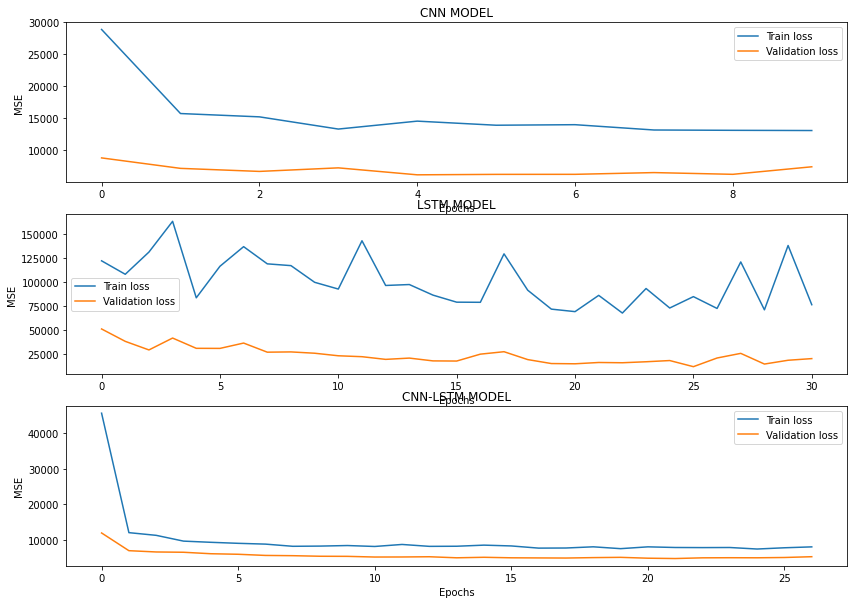

In [51]:
fig, axes = plt.subplots(3, 1, sharey=False,figsize=(14,10))
ax1 = axes[0]
ax2 = axes[1]
ax3 = axes[2]


ax1.plot(cnn_history.history['loss'], label='Train loss')
ax1.plot(cnn_history.history['val_loss'], label='Validation loss')
ax1.legend(loc='best')
ax1.set_title('CNN MODEL')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('MSE')

ax2.plot(lstm_history.history['loss'], label='Train loss')
ax2.plot(lstm_history.history['val_loss'], label='Validation loss')
ax2.legend(loc='best')
ax2.set_title('LSTM MODEL')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('MSE')

ax3.plot(cnn_lstm_history.history['loss'], label='Train loss')
ax3.plot(cnn_lstm_history.history['val_loss'], label='Validation loss')
ax3.legend(loc='best')
ax3.set_title('CNN-LSTM MODEL')
ax3.set_xlabel('Epochs')
ax3.set_ylabel('MSE')

plt.show()

**Evalutating RMSE for CNN, LSTM and CNN-LSTM model**

In [52]:
cnn_train_pred = cnn.predict(X_train_series)
cnn_valid_pred = cnn.predict(X_valid_series)
print('Train CNN rmse:', np.sqrt(mean_squared_error(Y_train, cnn_train_pred)))
print('Validation CNN rmse:', np.sqrt(mean_squared_error(Y_valid, cnn_valid_pred)))

81/81 [==============================] - 1s 8ms/step
Train CNN rmse: 94.77765229472872
Validation CNN rmse: 86.0500734191139


In [53]:
lstm_train_pred = lstm.predict(X_train_series)
lstm_valid_pred = lstm.predict(X_valid_series)
print('Train LSTM rmse:', np.sqrt(mean_squared_error(Y_train, lstm_train_pred)))
print('Validation LSTM rmse:', np.sqrt(mean_squared_error(Y_valid, lstm_valid_pred)))

81/81 [==============================] - 3s 32ms/step
Train LSTM rmse: 138.4329971392866
Validation LSTM rmse: 141.18675355593848


In [54]:
cnn_lstm_train_pred = cnn_lstm.predict(X_train_series_sub)
cnn_lstm_valid_pred = cnn_lstm.predict(X_valid_series_sub)
print('Train CNN-LSTM rmse:', np.sqrt(mean_squared_error(Y_train, cnn_lstm_train_pred)))
print('Validation CNN-LSTM rmse:', np.sqrt(mean_squared_error(Y_valid, cnn_lstm_valid_pred)))

81/81 [==============================] - 0s 4ms/step
Train CNN-LSTM rmse: 84.34564092221186
Validation CNN-LSTM rmse: 73.71874769468066


In this notebook I have used some of the Machine Learning and Deep Learning algorithm I came across while doing Time series forecast for Store Sales data from kaggle. 
Though from the visualization SARIMA model on both the validation and forecasts supports a good prediction model, the neural network models still outperformed the ARIMA.
The CNN model had the better fitting learning curve compared to the other two models. It looks like there was continued training loss up to a point of stability at different epochs. The validation loss also decreased up to a stable constant with a relatively small gap with the training loss. On all three models, the validation data "learned" and followed the same curve as the training data but at different levels. I also tried scaling the data before applying neural network models but all three were inefficient based on poor learning curves. Different learning rates were also explored but a higher than 0.00001 value resulted in models with poor learning curves.

On the CNN and CNN-LSTM algorithms, the RMSE had lower values but performed differently based on learning curves. The generalization gap on all three models, where the validation loss MSE is slighlty lower than the training loss MSE, makes them a good fit in evaluating performance. The CNN-LSTM model's learning curve showed the validation loss did not learn the data as well as the other 2 models. Based on RMSE of unseen data (validation data), the CNN model's learning curve had the best fit and makes this algorithm the better model.

Thank you for dropping by :) :)